# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.059819,False,0.125867
1,-1.090060,False,-2.634809
2,-0.481901,True,4.174310
3,-1.207703,False,-3.432447
4,-0.985325,True,4.303417
...,...,...,...
995,-1.165431,False,-3.515776
996,-0.192589,False,0.948743
997,-0.795401,True,4.216292
998,-1.427647,False,-3.466208


<AxesSubplot: xlabel='v0'>

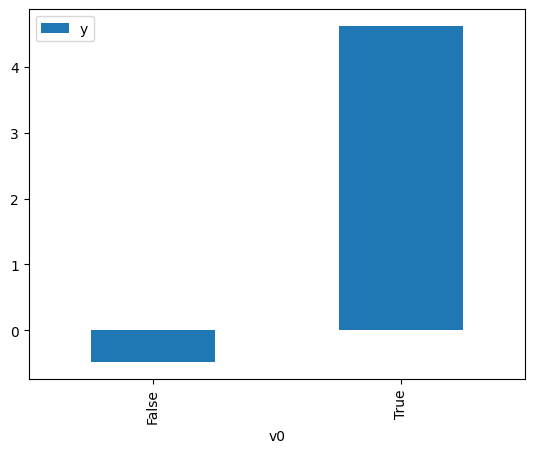

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

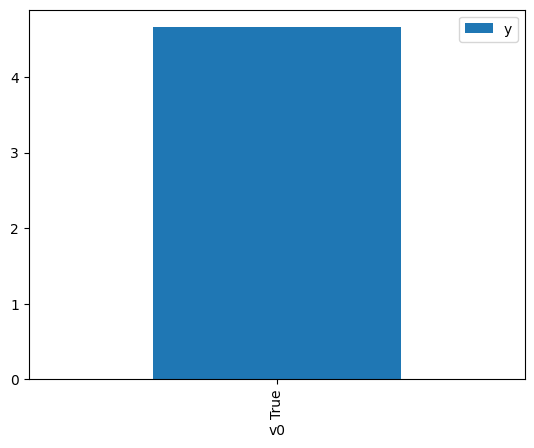

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.460876,False,0.703509,0.371494,2.691832
1,-0.007675,False,0.172301,0.507881,1.968963
2,-0.145153,False,0.956262,0.548611,1.822786
3,-0.355933,False,0.077058,0.609636,1.640324
4,0.410786,False,2.077614,0.385509,2.593974
...,...,...,...,...,...
995,-0.965477,False,-0.556716,0.763296,1.310108
996,-0.685439,False,-0.482467,0.697987,1.432692
997,0.490968,False,2.313934,0.363176,2.753489
998,0.175143,False,-0.436943,0.453650,2.204342


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.614233,True,1.907103,0.320161,3.123425
1,1.712178,True,9.429463,0.882284,1.133422
2,1.230096,True,7.320830,0.808579,1.236738
3,-1.521268,True,1.738626,0.138006,7.246049
4,-0.786872,True,3.426753,0.277202,3.607480
...,...,...,...,...,...
995,-1.488664,True,2.546330,0.142685,7.008445
996,0.266396,True,4.963375,0.573092,1.744920
997,-0.152268,True,4.917791,0.449294,2.225712
998,-1.173642,True,1.724435,0.194905,5.130700


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              9498.
Date:                Mon, 17 Oct 2022   Prob (F-statistic):                        0.00
Time:                        14:41:40   Log-Likelihood:                         -1417.0
No. Observations:                1000   AIC:                                      2838.
Df Residuals:                     998   BIC:                                      2848.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9310      0.032     60.823      0.000       1.869       1.993
x2             5.0581      0.048    105.398      0.000       4.964       5.152
==============================================================================
Omnibus:                        2.325   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                2.316
Skew:                           0.082   Prob(JB):                        0.314
Kurtosis:                       2.830   Cond. No.                         1.62
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""